# Inverting Kepler's equation in ODEs

In the [previous tutorial](<./Comparing coordinate systems.ipynb>) we considered the numerical solution of the Stark problem, whose Hamiltonian, in Cartesian coordinates, reads

$$
\mathcal{H}_\mathrm{cart}\left(v_x, v_y, v_z, x, y, z \right) = \frac{1}{2}\left( v_x^2+v_y^2+v_z^2 \right) - \frac{1}{\sqrt{x^2+y^2+z^2}} - \varepsilon z.
$$

We saw how a reformulation of the Stark problem using Delaunay elements, instead of Cartesian coordinates, can help reducing the total number of timesteps per unit of integration time. The Delaunay elements are the Hamiltonian version of the [Keplerian orbital elements](https://en.wikipedia.org/wiki/Orbital_elements), to which they are related via the following equations (valid in adimensional units):

$$
\begin{aligned}
L & = \sqrt{a}, & l & =  M, \\
G & = \sqrt{a\left( 1 - e^2\right)}, & g & = \omega, \\
H & = \sqrt{a\left( 1 - e^2\right)} \cos i, & h & =  \Omega.
\end{aligned}
$$

The Hamiltonian of the Stark problem in Delaunay elements reads:

$$
\mathcal{H}_\mathrm{Del} \left( L, G, H, l, g, h \right) = -\frac{1}{2L^2}-\varepsilon L\sqrt{1-\frac{H^2}{G^2}}\left[ L\left( \cos E - \sqrt{1-\frac{G^2}{L^2}} \right)\sin g + G\sin E \cos g \right].
$$

In this Hamiltonian, $E$ is the eccentric anomaly, which is a function of $L$, $G$ and $l$ implicitly defined by [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation):

$$
l = E - \sqrt{1-\frac{G^2}{L^2}} \sin E.
$$

Because Kepler's equation is trascendental, it cannot be inverted to yield an explicit expression for $E$ in terms of elementary functions. In the [previous tutorial](<./Comparing coordinate systems.ipynb>) we worked around this issue by leaving $E$ as an unspecified function in the Hamiltonian; we then augmented Hamilton's equations via the derivatives of $E$ (which can be formulated explicitly) and numerically solved the augmented system of differential equations.

Here we will employ a different approach, and we will use instead the function ``kepE()`` provided by heyoka.py's expression system. As the name suggests, ``kepE()`` represents symbolically the inversion of Kepler's elliptic equation. That is, ``kepE(e, M)`` is the bivariate function $E\left(e,M\right)$ implicitly defined by Kepler's elliptic equation:

$$
M = E - e \sin E.
$$

For the evaluation of ``kepE(e, M)`` heyoka.py uses an iterative numerical scheme. The high-order derivatives necessary to implement Taylor's integration method are built using automatic-differentiation techniques starting from the evaluation of ``kepE(e, M)``.

Let us begin by writing down the Hamiltonian:

In [1]:
import heyoka as hy

# Numerical value for the eps constant.
eps = 1e-3

# Symbolic variables for the Delaunay arguments.
L, G, H, l, g, h = hy.make_vars("L", "G", "H", "l", "g", "h")

# Define E as the solution to Kepler's equation.
E = hy.kepE(hy.sqrt(1-G**2*L**-2), l)

# The Hamiltonian.
Ham_del = -0.5*L**-2 - eps*L*hy.sqrt(1.-H**2*G**-2)*(L*(hy.cos(E)-hy.sqrt(1.-G**2*L**-2))*hy.sin(g)+G*hy.sin(E)*hy.cos(g))

Note how, in terms of Delaunay arguments, $e=\sqrt{1-\frac{G^2}{L^2}}$ and $M=l$.

Unlike in the [previous tutorial](<./Comparing coordinate systems.ipynb>), and thanks to the fact that ``kepE()`` supports symbolic differentiation, we can now use the standard formulation of Hamilton's equations:

In [2]:
# Define the system of ODEs.
sys = [(L, -hy.diff(Ham_del, l)),
       (G, -hy.diff(Ham_del, g)),
       (H, -hy.diff(Ham_del, h)),
       (l, hy.diff(Ham_del, L)),
       (g, hy.diff(Ham_del, G)),
       (h, hy.diff(Ham_del, H))]

We can now proceed to the creation of the integrator object. The initial conditions are taken from the [previous tutorial](<./Comparing coordinate systems.ipynb>):

In [3]:
ta = hy.taylor_adaptive(sys,
                        [1.0045488165591647, 0.9731906288081488, -0.9683287292736491,
                         2.776991035843252, 4.314274521695855, 3.3415926535897924])

Let us now integrate up to $t=250$ on a time grid. As usual, we will provide a callback to periodically reduce the $l$ angle modulo $2\pi$:

In [4]:
import numpy as np

# Callback to reduce l to the
# [-pi, pi] range.
def mod_cb_del(ta):
    
    l = ta.state[3]
    if l < -np.pi or l > np.pi:
        ta.state[3] = (l + np.pi) % (2 * np.pi) - np.pi
    
    return True

# Define a time grid for the integration.
t_grid = np.linspace(0, 250, 1000)

# Integrate.
_, _, _, _, _, out_del = ta.propagate_grid(t_grid, callback = mod_cb_del)

Let us take a look at the time evolution of the Delaunay elements:

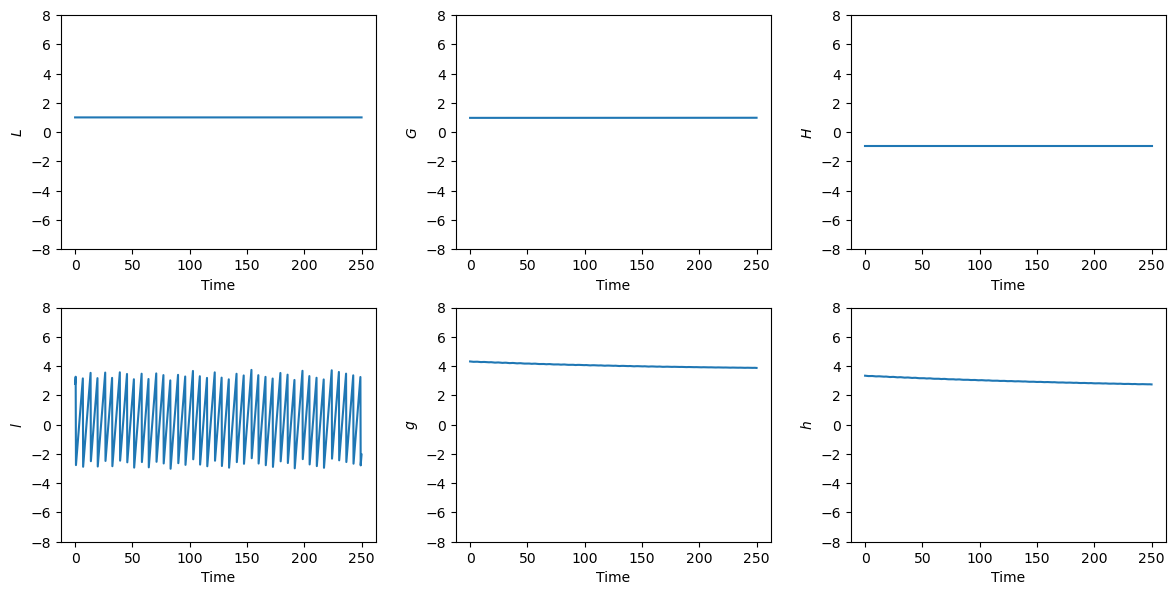

In [5]:
%matplotlib inline
from matplotlib.pylab import plt

def plot_t_evol(out, labels):
    fig = plt.figure(figsize = (12, 6))
    
    max_abs = 8
    
    ncoord = out.shape[1]
    ncols = 3
    nrows = ncoord // ncols + (ncoord % ncols)

    for i in range(0, ncoord):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.plot(t_grid, out[:, i])
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(-max_abs, max_abs)
    
    plt.tight_layout()

plot_t_evol(out_del, ["$L$", "$G$", "$H$", "$l$", "$g$", "$h$"])

It can be confirmed by direct numerical comparison that the integration of the Stark problem using ``kepE()`` produced results matching those from the [previous tutorial](<./Comparing coordinate systems.ipynb>) to machine precision.